In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tarfile
import math
from scipy import stats
import statsmodels.formula.api as smf

In [2]:
ds_clean = pd.read_csv('../data/data.csv', index_col=0)

In [3]:
ds_clean.head(3)

,Actor_name,Actor_gender,Actor_date_of_birth,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,averageRating,numVotes,genres,countries,box_office_adj
0,Dustin Farnum,M,1874-05-27,The Squaw Man,1914.0,244700.0,74.0,5.833333,1418,"[' ""Silent film""', ' ""Western""', ' ""Drama""', '...","[' ""United States of America""}']",6.117500e+06
1,Elmer Clifton,M,1890-03-14,The Birth of a Nation,1915.0,50000000.0,190.0,6.600000,46186,"[' ""Silent film""', ' ""Indie""', ' ""Costume dram...","[' ""United States of America""}']",1.250000e+09
2,Robert Harron,M,1893-04-12,The Birth of a Nation,1915.0,50000000.0,190.0,6.600000,46186,"[' ""Silent film""', ' ""Indie""', ' ""Costume dram...","[' ""United States of America""}']",1.250000e+09


# Data cleaning

In [4]:
#sort dataframes by ascending release year
ds_clean.sort_values(by=['Movie_release_date'], ascending=True, inplace=True)

## Preliminary results on the impact of one actor

In [5]:
#slice the character dataframe to get only Leonardo Di Caprio movies
nc = pd.DataFrame(ds_clean.query("Actor_name == 'Leonardo DiCaprio'")).reset_index(drop=True)
nc.drop_duplicates(subset=['Movie_name'], inplace=True) #drop duplicates to account for the possibility that an actor 
                                                        #has multiple roles in the same movie
nc.reset_index(drop=True, inplace=True)

In [6]:
#number of movies Leonardo Di Caprio starred in
print('Leonardo Di Caprio starred in ' + str(len(nc)) + ' movies')

Leonardo Di Caprio starred in 21 movies


In [7]:
nc.head(3)

,Actor_name,Actor_gender,Actor_date_of_birth,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,averageRating,numVotes,genres,countries,box_office_adj
0,Leonardo DiCaprio,M,1974-11-11,This Boy's Life,1993.0,4104962.0,114.0,7.300000,53559,"[' ""Family Drama""', ' ""Period piece""', ' ""Dram...","[' ""United States of America""}']",6.841603e+06
1,Leonardo DiCaprio,M,1974-11-11,What's Eating Gilbert Grape,1993.0,10032765.0,117.0,7.700000,238160,"[' ""Indie""', ' ""Slice of life story""', ' ""Amer...","[' ""United States of America""}']",1.672128e+07
2,Leonardo DiCaprio,M,1974-11-11,The Quick and the Dead,1995.0,18636537.0,105.0,7.178571,98184,"[' ""Thriller""', ' ""Japanese Movies""', ' ""Adven...","[' ""United States of America""', ' ""Japan""}']",2.911959e+07


As a preliminary analysis, we plot the distribution of box office revenues for Leonardo Di Caprio movies to see the type of distribution. From the histogram below, we observe that most of the movies have a low box office revenue (skewed distribution); the goal is to verify if there is a correlation between the 'experience' of the actor (number of times he has starred in the movie) and the revenue. 

From the box plot below it is possible to distinguish the median and the quartiles of the distribution. A couple of outliers make it difficult to visualize the distribution properly. To correctly read the data, we proceed to remove them.

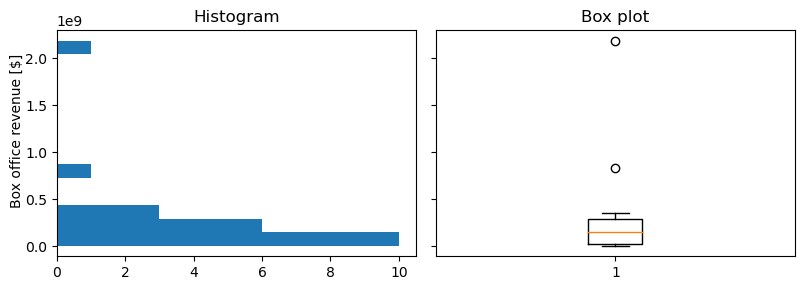

In [8]:
#plot distribution
fig, ax = plt.subplots(1,2, figsize=(8,3), sharey = True)

sbplt = ax[0]
sbplt.hist(nc.Movie_box_office_revenue, bins=15, orientation='horizontal')
sbplt.set_title('Histogram')

sbplt = ax[1]
sbplt.boxplot(nc.Movie_box_office_revenue)
sbplt.set_title('Box plot')
    
fig.tight_layout()
fig.text(0,0.3, "Box office revenue [$]", rotation = 90)
plt.show()

In [9]:
#remove outliers
nc.query('Movie_box_office_revenue < 0.5e9', inplace=True)
nc.reset_index(inplace=True, drop=True)
print('The new number of movies considered is ' + str(len(nc)))

The new number of movies considered is 19


In this case, the distribution is way more readable. Most of the movies are in the low box office part.

In [10]:
#some stats
print('The median is ' + str(np.median(nc.Movie_box_office_revenue)/1e6) + ' M$')
print('The first quartile is ' + str(np.quantile(nc.Movie_box_office_revenue,0.25)/1e6) + ' M$')
print('The third quartile is ' + str(np.quantile(nc.Movie_box_office_revenue,0.75)/1e6) + ' M$')

The median is 115.097286 M$
The first quartile is 14.334651 M$
The third quartile is 203.7569815 M$


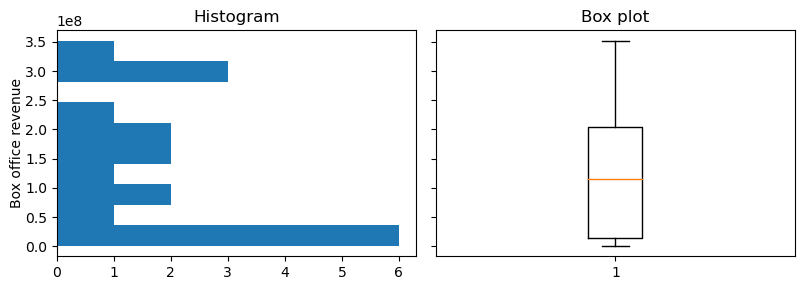

In [11]:
#plot again without outliers
fig, ax = plt.subplots(1,2, figsize=(8,3), sharey = True)

sbplt = ax[0]
sbplt.hist(nc.Movie_box_office_revenue, bins=10, orientation='horizontal')
sbplt.set_title('Histogram')

sbplt = ax[1]
sbplt.boxplot(nc.Movie_box_office_revenue)
sbplt.set_title('Box plot')
    
fig.tight_layout()
fig.text(0,0.3, "Box office revenue", rotation = 90)
plt.show()

### Actor's experience

We define the experience of the actor as the number of times he starred in a movie before, in relation to the dataset analyzed.

In [12]:
#define actor's experience
exp = np.zeros(len(nc)) 
t = 1
for i in range(len(nc)):
    exp[i] = t
    t += 1

In [13]:
#add experience column to dataframe
nc['experience'] = exp

We check for possible correlations between the experience and box office revenue

In [14]:
#pearson correlation
stats.pearsonr(nc['experience'],nc['Movie_box_office_revenue'])

(0.6024393468718816, 0.00633881816223416)

In [15]:
#spearman correlation
stats.spearmanr(nc['experience'],nc['Movie_box_office_revenue'])

SpearmanrResult(correlation=0.6491228070175438, pvalue=0.002636625075935029)

Applying the Pearson and Spearman relation, we obtain a positive correlation of **0.60** and **0.64**, respectively. This seems to lead to a link between experience and box office revenue, even if we still haven't proved statistaical significance.

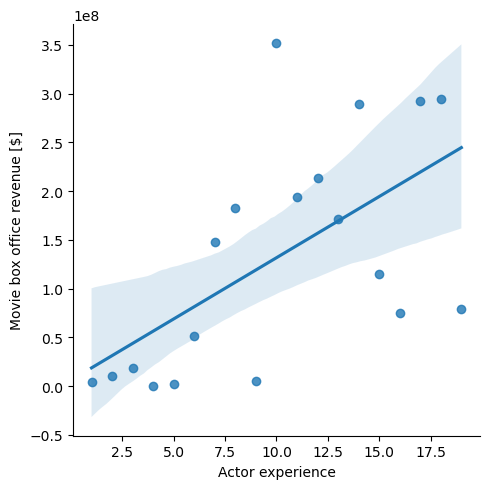

In [16]:
#plot linear correlation
sns.lmplot(x='experience',y='Movie_box_office_revenue', data=nc)
plt.ylabel('Movie box office revenue [$]')
plt.xlabel('Actor experience')
plt.show()

## Regression analysis

To understand a bit better the influence of the other parameters on the box office revenue, a model of the revenue based on multiple factors can be tested. The factors taken into consideration are:
- Movie runtime;
- Gender diversity in the cast;
- Experience.

Given that we already have the experience of the actor and movie runtime, we need to compute the male/female ratios for Leonardo DiCaprio movies.

In [17]:
#computation of actor/actress ratios
gd = nc.query("Actor_name == 'Leonardo DiCaprio'")['Movie_name'] #extract dataframe with Leonardo DiCaprio movies

gd_i = ds_clean[ds_clean['Movie_name'].isin(gd)] #extract rows including these movies from the original dataframe

In [18]:
#split dataframe into rows including actors and rows including actresses
gd_f = gd_i[gd_i['Actor_gender'] == 'F'] #dataframe only including actresses
gd_m = gd_i[gd_i['Actor_gender'] == 'M'] #dataframe only including actors

In [19]:
#group by the movie name and count the number of actors and actresses
n_f = gd_f.groupby('Movie_name')['Movie_name'].count() #number of actresses
n_m = gd_m.groupby('Movie_name')['Movie_name'].count() #number of actors

In [20]:
#create dataframe with male/female ratios
gender_ratios = pd.DataFrame(n_m.values/n_f.values)

In [21]:
#add to dataframe
nc['gender_ratios'] = gender_ratios

At this point, we can start the regression analysis.

In [22]:
#copy dataframe
nc_reg = nc.copy()

In [23]:
#logarithmic scaling of box office revenue
nc_reg['Movie_box_office_revenue'] = np.log(nc_reg['Movie_box_office_revenue'])

In [24]:
mod = smf.ols(formula='Movie_box_office_revenue ~  Movie_runtime +  experience + gender_ratios', data=nc_reg)

res = mod.fit()
print(res.summary())

                               OLS Regression Results                               
Dep. Variable:     Movie_box_office_revenue   R-squared:                       0.557
Model:                                  OLS   Adj. R-squared:                  0.469
Method:                       Least Squares   F-statistic:                     6.290
Date:                      Fri, 18 Nov 2022   Prob (F-statistic):            0.00562
Time:                              20:32:11   Log-Likelihood:                -31.833
No. Observations:                        19   AIC:                             71.67
Df Residuals:                            15   BIC:                             75.44
Df Model:                                 3                                         
Covariance Type:                  nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

/Users/isaacbattles/opt/anaconda3/envs/preprocessing/lib/python3.10/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


From the results, it is possible to get interesting information. The R squared is **0.56**, meaning more than half of the variance is explained. The movie runtime, the gender_ratios and the experience of the actor positively influence the revenue, even if only the latter is statistically significant (**P < 5%**).
A confounder that could naively lead us to overestimate the statistical significance of the actor's experience is inflation. Indeed, over the years the value of money changes; for a proper evaluation, an inflation correction has to be done.

In [25]:
#take inflation into account
cf = pd.read_csv('../data/inflation_correction.csv')
cf.reset_index(drop=True, inplace=True)

In [26]:
cf.head(3)

,Year,CF
0,1774.0,0.03
1,1775.0,0.03
2,1776.0,0.04


In [27]:
#function to compute inflation for a certain year
def infl(year):
    inf = cf['CF'][cf['Year'] == year]
    return inf

In [28]:
#compute inflation for dataframe rows
infl_corr = np.zeros(len(nc))
for i in range(len(nc)):
    infl_corr[i] = infl(nc['Movie_release_date'][i])
nc['CF'] = infl_corr #add column

In [29]:
#add inflation corrected box office revenue
nc['inflation_revenue'] = nc['Movie_box_office_revenue']/nc['CF']

In [30]:
nc.head(3)

,Actor_name,Actor_gender,Actor_date_of_birth,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,averageRating,numVotes,genres,countries,box_office_adj,experience,gender_ratios,CF,inflation_revenue
0,Leonardo DiCaprio,M,1974-11-11,This Boy's Life,1993.0,4104962.0,114.0,7.300000,53559,"[' ""Family Drama""', ' ""Period piece""', ' ""Dram...","[' ""United States of America""}']",6.841603e+06,1.0,8.000000,0.60,6.841603e+06
1,Leonardo DiCaprio,M,1974-11-11,What's Eating Gilbert Grape,1993.0,10032765.0,117.0,7.700000,238160,"[' ""Indie""', ' ""Slice of life story""', ' ""Amer...","[' ""United States of America""}']",1.672128e+07,2.0,3.000000,0.60,1.672128e+07
2,Leonardo DiCaprio,M,1974-11-11,The Quick and the Dead,1995.0,18636537.0,105.0,7.178571,98184,"[' ""Thriller""', ' ""Japanese Movies""', ' ""Adven...","[' ""United States of America""', ' ""Japan""}']",2.911959e+07,3.0,1.222222,0.64,2.911959e+07


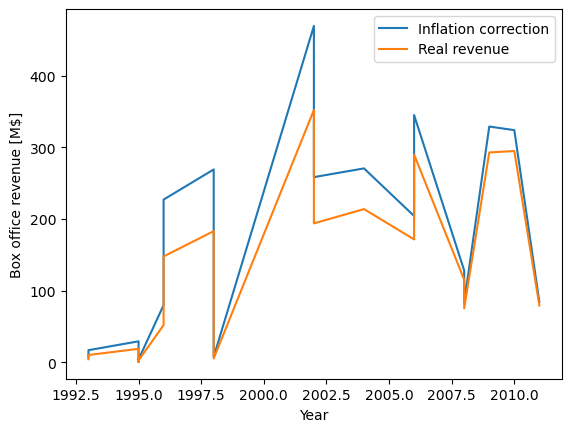

In [31]:
#compare the new revenues
plt.plot(nc.Movie_release_date, nc.inflation_revenue/1e6, label='Inflation correction')
plt.plot(nc.Movie_release_date, nc.Movie_box_office_revenue/1e6, label='Real revenue')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Box office revenue [M$]')
plt.show()

In [32]:
#run the linear regression again
nc_reg2 = nc.copy()
nc_reg2['inflation_revenue'] = np.log(nc_reg2['inflation_revenue'])

In [33]:
mod = smf.ols(formula='inflation_revenue ~ Movie_runtime + experience + gender_ratios', data=nc_reg2)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:      inflation_revenue   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     5.138
Date:                Fri, 18 Nov 2022   Prob (F-statistic):             0.0121
Time:                        20:32:25   Log-Likelihood:                -31.894
No. Observations:                  19   AIC:                             71.79
Df Residuals:                      15   BIC:                             75.57
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        12.3397      2.041      6.045

/Users/isaacbattles/opt/anaconda3/envs/preprocessing/lib/python3.10/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


From the new results above, it is possible to confirm the statistical significance of the experience on the box office (**P < 5%**), even if its influence has decreased (**C=0.17**), due to inflation, as we would expect.